In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from transformers import (
    GPT2Model, 
    GPT2Config
)
from typing import List, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from PIL import Image
import cv2

%matplotlib inline 

In [ ]:
# seed everything
def set_random_seed(seed, deterministic=False):
    """Set random seed.

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: False.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
set_random_seed(272)

## Task 0: Transfer Learning Setup
## Freeze Parameters
Freeze part of the parameters of pretrained GPT2 model before doing transfer learning by setting
$$
    Parameter.\text{requires_grad} = False
$$

In [ ]:
def gpt2_freezer(
    model,                         
    freeze_param_list: List[str] = None
):
  for (name, param) in model.named_parameters():
    if freeze_param_list is not None:
      if any([k in name for k in freeze_param_list]):
        param.requires_grad = False
    else:
      param.requires_grad = False
  return model

In [ ]:
pretrained_gpt2 = GPT2Model.from_pretrained('gpt2') 
pretrained_gpt2.config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.28.1",
  "use_cache": true,
  "vocab_size": 50257
}

In [ ]:
gpt2_engine = gpt2_freezer(
    pretrained_gpt2,
    ["mlp", "attn"]
  )

## Patchify Input Image

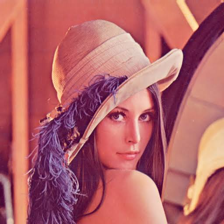

In [ ]:
def tensor2PIL(tensor: torch.Tensor):
    return transforms.ToPILImage()(tensor)

def display_patches(
    patches: torch.Tensor,
    n_patch: int
):
    
    fig, axes = plt.subplots(n_patch, n_patch)
    for i in range(n_patch):
        for j in range(n_patch):
            patch = patches[i*n_patch + j,:]
            axes[i][j].imshow(tensor2PIL(patch))
            axes[i][j].axis('off')
            
    plt.show()


def patchify(
    img: torch.Tensor,
    n_patch: int) -> torch.Tensor:
    
    b, c, h, w = img.shape
    patch_h = h // n_patch
    patch_w = w // n_patch
    patches = img.unfold(-1, patch_h, patch_h) \
                 .permute(0, 3, 1, 4, 2) \
                 .unfold(-1, patch_w, patch_w) \
                 .permute(0, 4, 1, 2, 5, 3)
    patches = torch.reshape(patches, (b, n_patch * n_patch, c, patch_h, patch_w,))
                 
    
    return patches
lenna = "https://i.stack.imgur.com/XKUT9.png"
img = Image.open(requests.get(lenna, stream=True).raw).resize((224, 224))
img

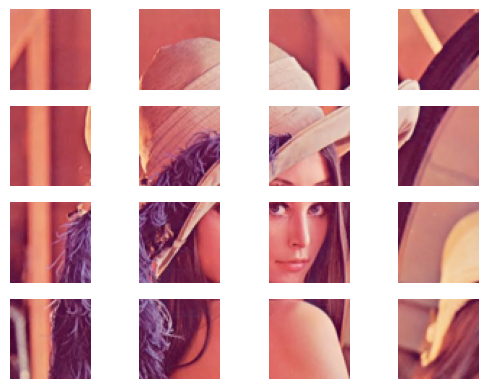

In [ ]:
transform = transforms.PILToTensor()
img = transform(img)
patches = patchify(img.unsqueeze(0), 4)
display_patches(patches[0], 4)

## Task 1: Image Classification on MNIST

In [ ]:
img_size = (28, 28)
batch_size = 32
transform = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize((0.1307,), (0.3081,))
      ])
trainset = torchvision.datasets.MNIST('./data', train=True, download=True,
                    transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=5)

testset = torchvision.datasets.MNIST('./data', train=False,
                      transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=5)

Design and train your own network using pretrained GPT2 model as main computational engine. You need to design
  * An input embedding layer, which projects your input to accommodate GPT2 input dimension
  * An output Linear layer and loss function

In [ ]:
class MNIST_clf(nn.Module):
  def __init__(self, engine, n_patch, input_dim, engine_embed_dim, n_class=10):
    super().__init__()
    self.n_patch = n_patch
    self.input_flatten = nn.Flatten(start_dim=-3, end_dim=-1)
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.cls_token = nn.Parameter(torch.randn(1, 1, engine_embed_dim) * 0.02)
    self.engine = engine
    self.out = nn.Linear(engine_embed_dim, n_class)
  def forward(self, x, output_attentions=False):
    x = patchify(x, self.n_patch)
    embeds = F.relu(
        self.input_embed(self.input_flatten(x))
    )
    B, _, _ = embeds.shape
    embeds = torch.concat([embeds, self.cls_token.repeat(B, 1, 1)], dim=-2)

    gpt2_output = self.engine(inputs_embeds=embeds, output_attentions=output_attentions)
    output = self.out(gpt2_output.last_hidden_state[:,-1])
    if output_attentions:
      return output, gpt2_output.attentions
    else:
      return output

## Visualizations

In [ ]:
def MNIST_unnormalize(x):
  return (x * 0.3081 + 0.1307) * 255


def logits_with_temp(logits, temp=0.2):
  logits = torch.exp(logits/temp)
  logits = logits / torch.sum(logits)
  return logits

def visualize_attn_on_image(img, model):
  '''
      Input: 
        img   -> normalized img
        model -> transformer model to obtain attention map for each layer
  '''
  # nifty way to check whether model is on cuda
  img = img.to(next(model.parameters()).device)

  with torch.no_grad():
    _, attentions = model(img.unsqueeze(0), output_attentions=True)
  
  attentions = torch.stack([attn.squeeze(0).mean(dim=0) for attn in attentions], dim=0).cpu()

  # accounting for residual connnection, then renormalize attention
  augmented_attn = attentions + torch.eye(attentions.shape[-1])
  augmented_attn = augmented_attn / augmented_attn.sum(dim=-1).unsqueeze(-1)

  # rolled_out_attn = torch.eye(augmented_attn.shape[-1])
  # for layer_idx in range(augmented_attn.shape[0]):
  #   rolled_out_attn = augmented_attn[layer_idx] @ rolled_out_attn

  mask = logits_with_temp(augmented_attn[-1,-1,:-1], 0.05) \
         .reshape(4, -1)

  mask = np.ascontiguousarray(
      (mask/mask.max()).detach().numpy()
  )
  mask = cv2.resize(mask, (28, 28))

  img = MNIST_unnormalize(
      img.squeeze(0).cpu().detach().numpy()
  )
  return (img * mask).astype('uint8')

def display_MNIST_with_attn(img_batch, model, img_size=(16,16)):
  n = img_batch.shape[0]
  fig, axs = plt.subplots(nrows=n, ncols=2, figsize=img_size)

  axs[0, 0].set_title('Original')
  axs[0, 1].set_title('Attention Map')
  for i, img in enumerate(img_batch):

    attn_map = visualize_attn_on_image(
        img, 
        model
    )
    img = MNIST_unnormalize(img).squeeze(0).cpu().numpy().astype('uint8')

    axs[i, 0].imshow(img)
    axs[i, 1].imshow(attn_map)
  fig.tight_layout()


## Zero Shot Prediction

In [ ]:
assert torch.cuda.is_available()
device = torch.device('cuda')
model = MNIST_clf(
    gpt2_engine, 
    n_patch = 4,
    input_dim = 49, 
    engine_embed_dim = 768
).to(device)

model = model.to(device)

acc = 0
model.eval()
for i, data in enumerate(testloader):
  inputs, labels = data
  inputs = inputs.to(device); labels = labels.to(device)
  with torch.no_grad():
    pred = model(inputs).argmax(-1)
    acc += sum(pred == labels)

print("Accuracy: {:.2f}%".format(100 * acc/len(testloader.dataset)))

Accuracy: 9.82%


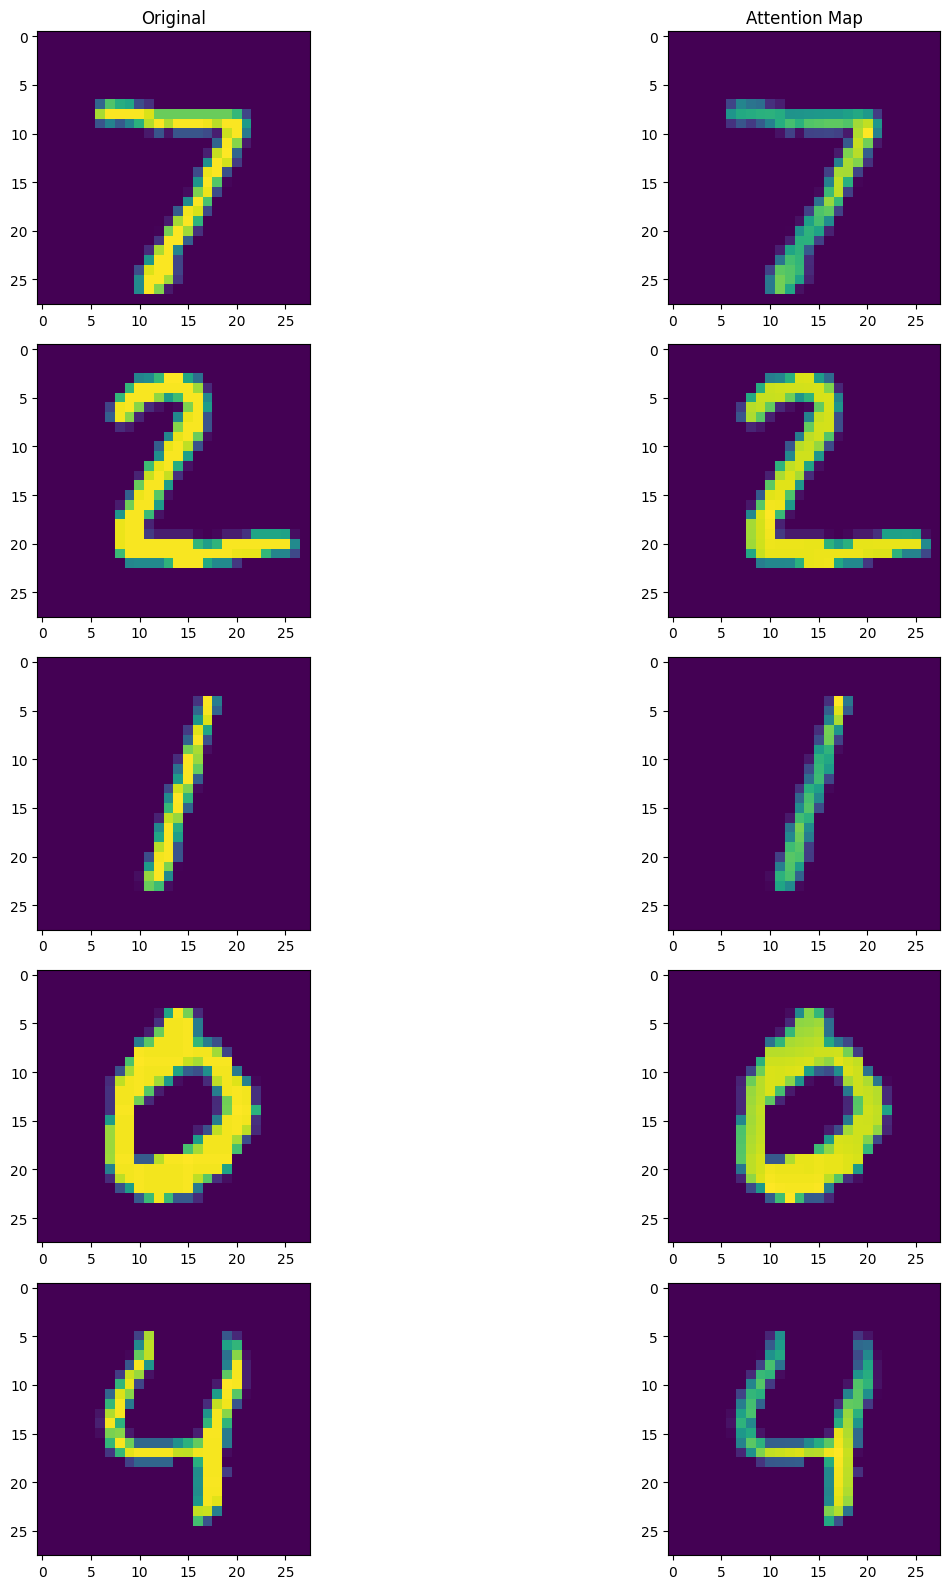

In [ ]:
batch_x, batch_y = next(iter(testloader))
display_MNIST_with_attn(batch_x[:5], model)

## Traint the model using GPT2 as main computation engine

In [ ]:
assert torch.cuda.is_available()
device = torch.device("cuda")


model = MNIST_clf(
    gpt2_engine, 
    n_patch = 4,
    input_dim = 49, 
    engine_embed_dim = 768
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(3):  

    # running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader)):
        inputs, labels = data
        inputs = inputs.to(device); labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # running_loss += loss.item()

print('\nFinished Training')

100%|██████████| 1875/1875 [02:30<00:00, 12.46it/s]


Finished Training


In [ ]:
# Test performance of model
acc = 0
model.eval()
for i, data in enumerate(testloader):
  inputs, labels = data
  inputs = inputs.to(device); labels = labels.to(device)
  with torch.no_grad():
    pred = model(inputs).argmax(-1)
    acc += sum(pred == labels)

print("Accuracy: {:.2f}%".format(100 * acc/len(testloader.dataset)))


Accuracy: 81.86%


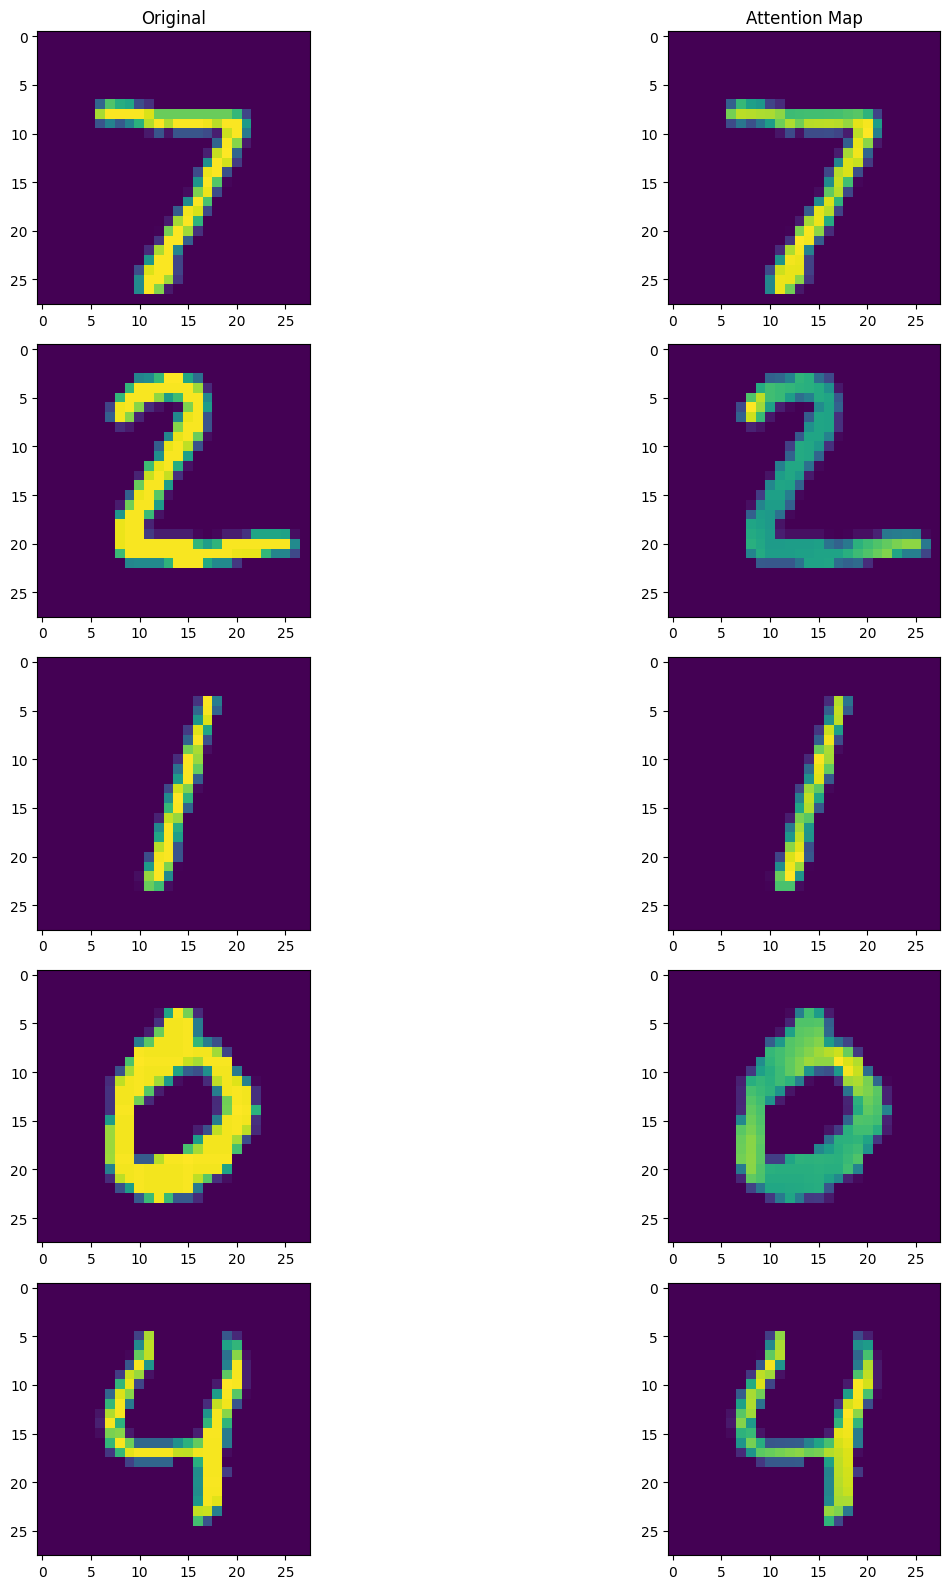

In [ ]:
batch_x, batch_y = next(iter(testloader))
display_MNIST_with_attn(batch_x[:5], model)

## Task 2: Object Detection on Pascal VOC 2012

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# some visualization
def plot_bbox(img_tensor: torch.Tensor, box: torch.Tensor):
  # box (x_min, y_min, x_max, y_max)

  # unormalize bounding box
  _, w_img, h_img = img_tensor.shape

  bbox_width = box[-2] * w_img
  bbox_height = box[-1] * h_img
  x_min = box[0] * w_img - (bbox_width/2)
  y_min = box[1] * h_img - (bbox_height/2)

  box = torch.Tensor(
      [x_min, y_min, x_min + bbox_width, y_min + bbox_height]
  )


  # unormalize image
  _mean = torch.Tensor(mean).view(-1, 1, 1)
  _std = torch.Tensor(std).view(-1, 1, 1)
  img_tensor = img_tensor * _std + _mean

  img_array = (img_tensor.cpu().numpy().transpose(1, 2, 0) * 255).astype("uint8")

  img_array = np.ascontiguousarray(img_array)

  box = box.cpu().numpy().astype('int32')
  top_left = (box[0], box[1])
  low_right = (box[2], box[3])
  img_array = cv2.rectangle(img_array, top_left, low_right, (0, 255, 0), 2)
  plt.imshow(img_array)

In [ ]:
img_size = (112, 112)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

def img_bbox_transform(img, annotations):
  # extract bounding box from annotations
  bbox = annotations['annotation']['object'][0]['bndbox']

  # scale bounding box accordingly
  x_min, y_min, x_max, y_max= [float(i) for i in bbox.values()]
  x, y = img.size
  x_scale = img_size[0]/x; y_scale = img_size[1]/y


  x_min *= x_scale; x_max *= x_scale
  y_min *= y_scale; y_max *= y_scale

  bbox_width = x_max - x_min
  bbox_height = y_max - y_min
  
  w_img, h_img = img_size

  resized_bbox = torch.Tensor(
      [
          (x_min + bbox_width/2) / w_img, (y_min + bbox_height/2) / h_img,
          bbox_width / w_img, bbox_height / h_img
       ]
  )

  # normalize bounding box 

  transform = transforms.Compose(
      [
          transforms.Resize(img_size),
          transforms.ToTensor(),
          transforms.Normalize(mean, std),
      ]
  )
  resized_img = transform(img)
  return resized_img, resized_bbox

batch_size = 32


trainset = torchvision.datasets.VOCDetection('./data', '2012', image_set="train", download=True,
                                             transforms=img_bbox_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.VOCDetection('./data', '2012', image_set="val", download=True,
                                            transforms=img_bbox_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


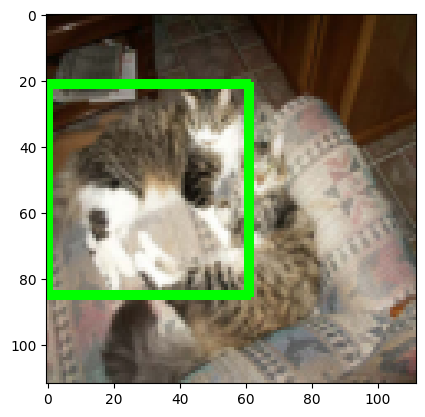

In [ ]:
data, target = trainset[1236]
target
plot_bbox(data, target)

In [ ]:
class VOC2012_reg(nn.Module):
  def __init__(self, engine, n_patch, input_dim, engine_embed_dim):
    super().__init__()
    self.n_patch = n_patch
    self.input_flatten = nn.Flatten(start_dim=-3, end_dim=-1)
    self.input_embed = nn.Linear(input_dim, engine_embed_dim)
    self.cls_token = nn.Parameter(torch.randn(1, 1, engine_embed_dim) * 0.02)
    self.engine = engine
    self.out = nn.Linear(engine_embed_dim, 4)
  def forward(self, x):
    x = patchify(x, self.n_patch)
    embeds = F.relu(
        self.input_embed(self.input_flatten(x))
    )
    B, _, _ = embeds.shape
    embeds = torch.concat(
        [self.cls_token.repeat(B, 1, 1), embeds], dim=1
    )
    hidden_state = self.engine(inputs_embeds=embeds).last_hidden_state[:,0]
    output = self.out(hidden_state)
    return output

In [ ]:
assert torch.cuda.is_available()
device = torch.device("cuda")


model = VOC2012_reg(
    gpt2_engine, 
    n_patch = 14,
    input_dim = 64 * 3, 
    engine_embed_dim = 768
).to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(3):  

    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader)):
        inputs, labels = data
        inputs = inputs.to(device); labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


100%|██████████| 179/179 [02:30<00:00,  1.19it/s]

Finished Training


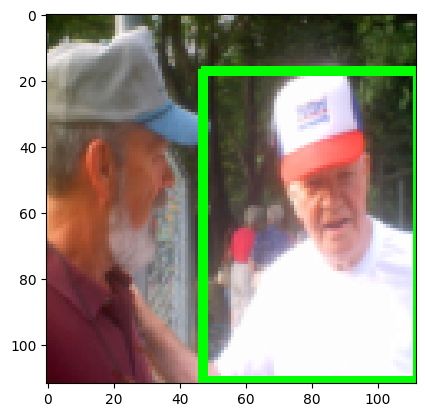

In [ ]:
data, target = testset[180]
plot_bbox(data, target)

tensor([0.5709, 0.4808, 0.1753, 0.2240])


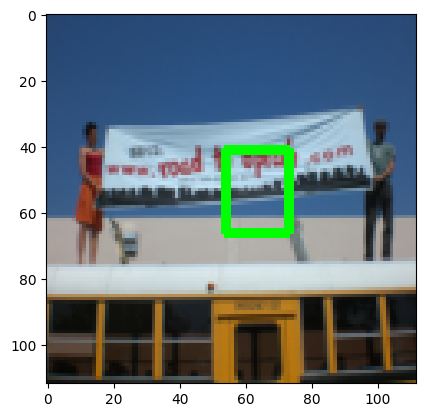

In [ ]:
data, target = trainset[28]
pred = model(data.to(device).unsqueeze(0)).cpu()
pred = pred[0].detach()
print(pred)
plot_bbox(data, pred.detach())